![Py4Eng](img/logo.png)

# Statistics
## Yoav Ram

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats
import scipy.special as spec
import urllib.request
import os.path
import zipfile
import pandas as pd
import seaborn as sns
sns.set(
    style='white',
    context='talk'
)
np.random.seed(847)

Some of the presented exercises follow the book [IPython Cookbook](http://ipython-books.github.io/cookbook/) by [Cyrille Rossant](http://cyrille.rossant.net/).

# One sample mean hypothesis tests

Let's write a function that flips a coin `n` times and returns the number of times it landed on *head*. It's a special coin - the probability that it falls on *head* is `q`:

In [81]:
def flip(n, q=0.5):
    randoms = np.random.random(n)
    heads = randoms < q
    return heads.sum()

In [82]:
n = 100
q = 0.5
x = flip(n, q=0.54)
x

55

Say we don't know what `q` is and we want to check if the coin is fair - that is, if `q` is 0.5. We can use a *hypothesis test* for this purpose. 

Our *null hypothesis* is $H_0: q=0.5$, whereas our alternative hypothesis is $H_A: q \ne 0.5$.

We will use the [z-test](https://en.wikipedia.org/wiki/Z-test) which can be applied when our measurement is roughly  normally distributed. 
This should be fine as the number of heads is binomially distributed with an expected value that is high ($nq=50$).

We can check this by plotting a histogram of many experiments:

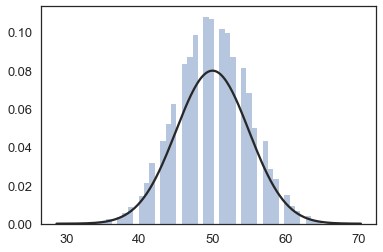

In [83]:
experiments = np.array([flip(n, q) for _ in range(10000)])
sns.distplot(experiments, kde=False, fit=scipy.stats.norm);

Hmmm... This doesn't look normal... We can use a normality test from SciPy:

In [84]:
scipy.stats.normaltest(experiments)

NormaltestResult(statistic=2.2811109057070187, pvalue=0.31964142675543705)

The p-value is quite high so we didn't reject the hypothesis that the sample is normal, therefore we will proceed with the z-test.

Under the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem)
$$
\frac{\sum{x_i} - n\mu}{\sigma} \to N(0,1)
$$
where $x_i$ are identically and independently distributed, $\mu$ is the expectation of $x_i$, $\sigma$ is the standard deviation of $x_i$, and $N(0,1)$ is the standard normal distribution.

Under the null hypothesis, the expectation of $x_i$ is $q$ and the standard deviation is $\sqrt{q(1-q)/n}$.
The test statistic is therefore
$$
z =  \frac{x-nq}{\sqrt{nq(1-q)}}
$$
where $x$ is the fraction of flips that were head,
and we can test if it is reasonable that $z \sim N(0,1)$, i.e. calculate the probability that $z$ is drawn from a standard normal distribution.

In [90]:
z = (x - n * q) / np.sqrt(n * q * (1 - q))
z

1.0

Because of the way we calculated $z$, we know that if the null hypothesis is true, then `z` is drawn from a standard normal distribution (at least for large `n`, due to the *Central Limit Theorem*).

Therefore, we can calculate the *P-value*, or the probability to get a value more extreme than `z` (i.e. larger than `z` or smaller than `-z`):

$$
p = P(|Z| > z) \approx 2 ( 1 - \phi(z) )
$$
where $\phi$ is the *cummulative probabiltiy function* of the standard normal distribution.

P-value: 0.32, Reject null hypothesis: False


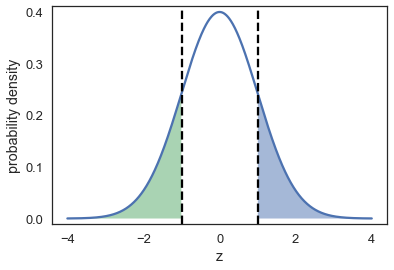

In [100]:
Z = scipy.stats.norm(0, 1) # standard normal distribution
t = np.linspace(-4, 4, 1000)

plt.plot(t, Z.pdf(t))
plt.axvline(z, color='k', ls='--')
plt.axvline(-z, color='k', ls='--')
plt.fill_between(t[t>z], Z.pdf(t[t>z]), alpha=0.5)
plt.fill_between(t[t<-z], Z.pdf(t[t<-z]), alpha=0.5)
plt.ylabel('probability density')
plt.xlabel('z')
plt.ylim(-0.01, 0.41)

pval = 2 * (1 - scipy.stats.norm.cdf(z))
print("P-value: {0:.2g}, Reject null hypothesis: {1}".format(pval, pval < 0.05))

## Using tests in scipy.stats

We could, instead, use an exact [binomial test](https://en.wikipedia.org/wiki/Binomial_test), which works for smaller `n` (sample size) and doesn't assume normality of the data.

In [101]:
pval = scipy.stats.binom_test(x, n=n, p=q)
print("P-value: {0:.2g}, Reject null hypothesis: {1}".format(pval, pval < 0.05))

P-value: 0.37, Reject null hypothesis: False


## Exercise

Consider `x`, an array of 50 experimental measurements.
We would like to use a [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test) to test the null hypothesis that the expected/real value of the measurement is 75. 

Use the function `scipy.stats.ttest` to calculate a P-value and make an hypothesis test (with a significance level of 0.05).

NormaltestResult(statistic=1.1267782586969139, pvalue=0.56927643925366289)

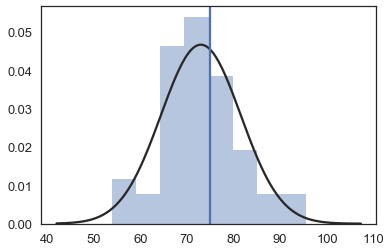

In [15]:
x = np.array([ 65.53023244,  72.23747986,  73.01265677,  89.9351998 ,
        70.6963815 ,  78.02590763,  81.2881422 ,  61.80569525,
        65.93705786,  70.54059758,  77.49758326,  68.42851182,
        68.55585283,  80.1871511 ,  74.65777598,  65.20851364,
        68.50039697,  65.90256468,  73.32305696,  74.03947153,
        77.1472388 ,  72.02604829,  82.7751142 ,  59.6132927 ,
        55.048079  ,  70.01523156,  90.5524559 ,  73.56715484,
        65.19466857,  76.66137409,  71.11086989,  58.7251773 ,
        53.9227519 ,  78.80348065,  65.70707516,  71.64598738,
        78.4655557 ,  68.55593575,  95.4389177 ,  65.28104808,
        79.67603416,  73.25855752,  67.59741922,  88.1492883 ,
        83.2779776 ,  80.9657968 ,  72.18488899,  76.23291307,
        76.50505861,  76.31360889])
sns.distplot(x, kde=False, fit=scipy.stats.norm)
plt.axvline(75)
scipy.stats.normaltest(x)

# Correlation

Next, we will use some tennis data to show how to calculate correlations and their statistical significance.

Start by downloading the data from the [IPython Cookbook: example data](https://github.com/ipython-books/cookbook-data) repo.

In [103]:
filename = '../data/tennis.zip'
if not os.path.exists(filename):
    urllib.request.urlretrieve('https://github.com/ipython-books/cookbook-data/raw/master/tennis.zip', filename)
print("Data file exists:", os.path.exists(filename))

zf = zipfile.ZipFile(filename)
for f in zf.filelist: 
    print(f.filename)

Data file exists: True
data/Andy-Murray.csv
data/Novak-Djokovic.csv
data/Rafael-Nadal.csv
data/Roger-Federer.csv


We have data for four prolific tennis player. We'll go with Novak Djokovic.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/28/Novak_Djokovic_2007_US_Open.jpg/320px-Novak_Djokovic_2007_US_Open.jpg)

In [104]:
player = 'Novak Djokovic'
with zf.open('data/{}.csv'.format(player.replace(' ', '-'))) as f:
    df = pd.read_csv(f)
df.head()

,year,tournament,start date,type,surface,draw,atp points,atp ranking,tournament prize money,round,...,player2 2nd serve return points total,player2 break points converted won,player2 break points converted total,player2 return games played,player2 total service points won,player2 total service points total,player2 total return points won,player2 total return points total,player2 total points won,player2 total points total
0,2003,"Serbia F6, Beograd",28.07.2003,FU,Outdoor: Clay,Draw: 32,4,709.0,$480,R32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003,"Serbia F6, Beograd",28.07.2003,FU,Outdoor: Clay,Draw: 32,4,709.0,$480,R16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003,"Serbia F6, Beograd",28.07.2003,FU,Outdoor: Clay,Draw: 32,4,709.0,$480,Q,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003,"Serbia F6, Beograd",28.07.2003,FU,Outdoor: Clay,Draw: 32,4,709.0,$480,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003,"Serbia F5, Beograd",21.07.2003,FU,Outdoor: Clay,Draw: 32,NaN,774.0,$118,R32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We'll start by plotting the % of points won by Novak vs the % of points he aced.
We'll use different markers for wins and losses.

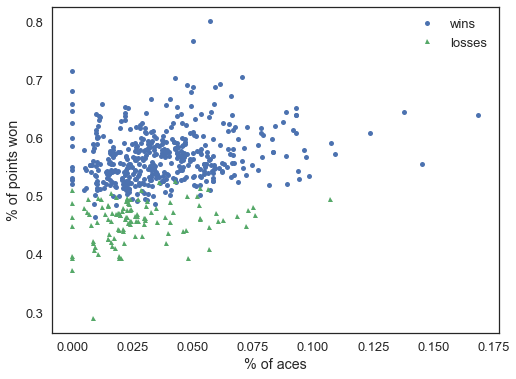

In [105]:
npoints = df['player1 total points total']
points = df['player1 total points won'] / npoints
aces = df['player1 aces'] / npoints

player1_won = df['winner'] == player

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(aces[player1_won], points[player1_won], 'o', markersize=5,  label='wins')
plt.plot(aces[~player1_won], points[~player1_won], '^', markersize=5, label='losses')
plt.xlabel('% of aces')
plt.ylabel('% of points won')
plt.legend();

Obviously % of points won is a strong indicator of winning; % of aces seems also to be an indicator, but not as strong, and there seems to be some correlation between aces and points won.

Let's calculate the correlation between % points won and % of aces. We use [*Pearson's linear correlation*](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient). 

First, we create a new data frame just with the relevant data:

In [107]:
df_cor = pd.DataFrame(
    {
        'points': points, 
        'aces': aces
    }
).dropna()
df_cor.tail()

,aces,points
725,0.059322,0.686441
726,0.066372,0.557522
727,0.015873,0.555556
728,0.031884,0.533333
729,0.024390,0.523035


Then we calculate the (symmetric) correlation matrix:

In [108]:
df_cor.corr() # default method is "pearson"

,aces,points
aces,1.000000,0.280572
points,0.280572,1.000000


A correlation coefficient of 0.28 is suggestive of a positive correlation. 

We want to estimate the statistical significance of the correlation between the variables.
For this purpose we use a *chi-squared test* of the independence of variables in a contingency table.

First, we binarize our variables. Here, the value corresponding to the number of aces is `True` if the player is serving more aces than usual in a match, and `False` otherwise. Similarly, we define the `result` as `True` if the % of points is larger than usual and `False` otherwise.

We then create a contingency table:

In [109]:
df_bis['result'] = df_bis['points'] > df_bis['points'].median()
df_bis['manyaces'] = df_bis['aces'] > df_bis['aces'].median()

contingency_table = pd.crosstab(df_bis['result'], df_bis['manyaces'])
contingency_table

manyaces,False,True
result,,
False,178,105
True,105,177


We can see that the main diagonal (`False-False` and `True-True`) is heavier then the cross diagonal.
To quantify this, we use the `ch2_contingency` function to calculate the P-value - the probability to get this table given the null hypothesis that above aces and points are independent:

In [111]:
chi2, p, dof, ex = scipy.stats.chi2_contingency(contingency_table)
print("P-value: {0:.2g}, Reject null hypothesis: {1}".format(p, p < 0.05))

P-value: 1.8e-09, Reject null hypothesis: True


## Exercise

It is commonly said that [Rafael Nadal](https://en.wikipedia.org/wiki/Rafael_Nadal) is a dominant clay player.

![Rafa on clay](https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/Nadal_2010_Madrid_01.jpg/330px-Nadal_2010_Madrid_01.jpg)

Let's examine if indeed there is a correlation between the surface Rafa plays on and his winning.

The following cell loads the data for Rafa, discards surfaces on which he played less than 100 matches, and plots a bar plots of the results

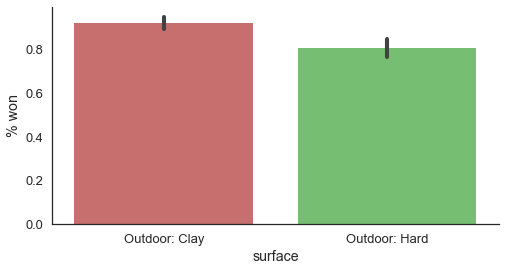

In [112]:
player = 'Rafael Nadal'
with zf.open('data/{}.csv'.format(player.replace(' ', '-'))) as f:
    df = pd.read_csv(f)

surface_count = df['surface'].value_counts()
surfaces = surface_count[surface_count > 100].index
df = df[df['surface'].isin(surfaces)]
df['win'] = df.winner == player

fig = plt.figure(figsize=(8, 4))
_, green, red = sns.color_palette('muted', 3)
sns.set_palette([red, green])
sns.barplot('surface', 'win', data=df)
plt.ylabel('% won')
sns.despine()

Indeed it seems that the probability of winning is higher on clay for Rafa. 

**Use a contingency table** to perform a chi-sqaure test to test the null hypothesis that winning is independent of surface for Rafa.

In [16]:
# Your code here

surface,Outdoor: Clay,Outdoor: Hard
win,,
False,28,64
True,329,268


In [17]:
# Your code here
print("P-value: {0:.2g}, Reject null hypothesis: {1}".format(p, p < 0.05))

P-value: 1.7e-05, Reject null hypothesis: True


# Estimating distributions

SciPy has builtin functions to estimate probability distributions from data using [*Maximum Likelihood Estimators*](http://en.wikipedia.org/wiki/Maximum_likelihood) (MLE).

Let's load some transplant survival data (originally from *Miller, R. (1976). Least squares regression with censored dara. Biometrica, 63 (3). 449-464*). This data contains the survival time after receiving a heart transplant.

In [114]:
df = pd.read_csv('../data/heart.csv')
df.head()

,survival
0,15.0
1,3.0
2,624.0
3,46.0
4,127.0


We start by plotting the survival data for each patient, by descending survival, and the histogram of the survival data.

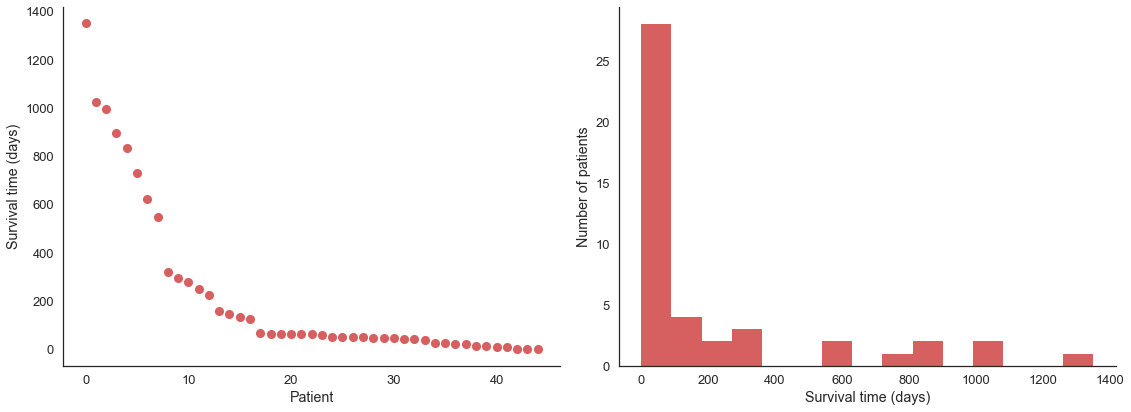

In [115]:
survival = df.survival

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(sorted(survival)[::-1], 'o')
ax[0].set(xlabel='Patient', ylabel='Survival time (days)')

ax[1].hist(survival, bins=15)
ax[1].set(xlabel='Survival time (days)', ylabel='Number of patients')

fig.tight_layout()
sns.despine()

It seems that the histogram is decreasing rapidly (this is data from the 1970's), so we will try to fit an exponential distribution to the data.

We do this using the `scipy.stats.expon` class which has a `fit` class method (as do all the distribution classes). This function calculates a MLE of the distribution and returns the distribution paramters (the location and scale, in this case).

In [131]:
params = scipy.stats.expon.fit(survival)
print(params)

(0.99999999994836486, 222.28880590143666)


If we want to plot the histogram with a fitted distribution, we can just use seaborn, as exeplified above:

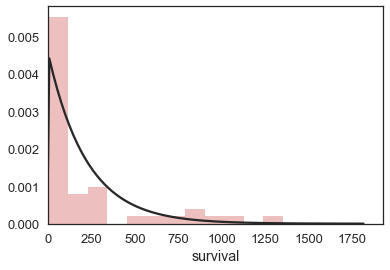

In [132]:
sns.distplot(survival, kde=False, fit=scipy.stats.expon)
plt.xlim(0, None);

This doesn't look that good. A statistical test for the fit of the distribution to the data (a statistical quantification to the statement "this doesn't look that good") can be done with the [Kolmogorov-Smirnov goodness of fit test](http://en.wikipedia.org/wiki/Kolmogorov-Smirnov_test) implemented in the `scipy.stats.kstest` function. The null hypothesis in this case is that the data came from the estimated exponential distribution.

In [134]:
fitted_expon = scipy.stats.expon(*params)
D, p = scipy.stats.kstest(survival, fitted_expon.cdf)
print("Exponential distribution")
print("P-value: {0:.2g}, reject null hypothesis: {1}".format(p, p < 0.05))

Exponential distribution
P-value: 8.6e-06, reject null hypothesis: True


Indeed, we reject the null hypothesis - the exponential distribution is unlikely for this dataset.

## Exercise

Let's try a different distribution, the [fatigue life distribution](https://en.wikipedia.org/wiki/Birnbaum%E2%80%93Saunders_distribution), used extensively in reliability applications to model failure times.

Fit the distribution to the data, test it with the `kstest`, and plot it with the data and the exponential distribution for comparison.

**Note** the fatigue-life distribution has three parameters whereas the exponential distribution has two, so we should probably use another statistical method to decide on the correct model, such as [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion)

# Estimating a probability distribution with a kernel density estimation

Sometimes we don't have an idea as to what is the *real* distribution of the data.
In these cases we can perform non-parameteric estimation to fit an arbitrary family of function to the data distribution. 

Here, we use a [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE).
For example, seaborn will automatically use KDE with a gaussian kernel if we use `distplot`:

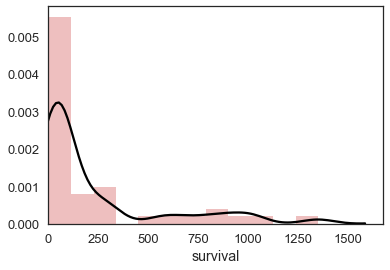

In [139]:
sns.distplot(survival, kde_kws=dict(color='k'))
plt.xlim(0, None);

We'll now use KDE to estimate the density of a spatial empirical distribution.
We look at the geographical locations of tropical [cyclones](https://en.wikipedia.org/wiki/Cyclone) (sometimes known as hurricanes, typhoons, or tornados) from 1848 to 2013, based on data provided by the NOAA, the US' National Oceanic and Atmospheric Administration.

We'll need the [CatroPy](http://scitools.org.uk/cartopy/) package, which is a *Matplotlib* add-on that displays maps.

In [3]:
import cartopy.crs as ccrs

We load the storms data set from the [IPython Cookbook data repo](https://github.com/ipython-books/cookbook-data).

In [6]:
url = 'https://github.com/ipython-books/cookbook-data/raw/master/storms.zip'
filename = '../data/storms.zip'
if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)
print("Data file exists:", os.path.exists(filename))

zf = zipfile.ZipFile(filename)
with zf.open('data/Allstorms.ibtracs_wmo.v03r05.csv') as f:
    df = pd.read_csv(f)
df.head()

Data file exists: True


,Serial_Num,Season,Num,Basin,Sub_basin,Name,ISO_time,Nature,Latitude,Longitude,Wind(WMO),Pres(WMO),Center,Wind(WMO) Percentile,Pres(WMO) Percentile,Track_type
0,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-11 06:00:00,NR,-8.6,79.8,0.0,0.0,reunion,-100.0,-100.0,main
1,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-12 06:00:00,NR,-9.0,78.9,0.0,0.0,reunion,-100.0,-100.0,main
2,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-13 06:00:00,NR,-10.4,73.2,0.0,0.0,reunion,-100.0,-100.0,main
3,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-14 06:00:00,NR,-12.8,69.9,0.0,0.0,reunion,-100.0,-100.0,main
4,1848011S09080,1848,2,SI,MM,XXXX848003,1848-01-15 06:00:00,NR,-13.9,68.9,0.0,0.0,reunion,-100.0,-100.0,main


The interesting columns for us are:

In [7]:
df = df[['Serial_Num', 'Season', 'Basin', 'Latitude', 'Longitude']]
df.head()

,Serial_Num,Season,Basin,Latitude,Longitude
0,1848011S09080,1848,SI,-8.6,79.8
1,1848011S09080,1848,SI,-9.0,78.9
2,1848011S09080,1848,SI,-10.4,73.2
3,1848011S09080,1848,SI,-12.8,69.9
4,1848011S09080,1848,SI,-13.9,68.9


The dataset contains information about most storms since 1848. A single storm may appear multiple times across several consecutive days. We group the data by `Serial_num` (storm identifier) and aggregate to get the average location of every storm:

In [9]:
dfs = df.groupby('Serial_Num')
pos = dfs[['Latitude', 'Longitude']].mean()
pos.head()

,Latitude,Longitude
Serial_Num,,
1848011S09080,-15.918182,71.854545
1848011S15057,-24.116667,52.016667
1848061S12075,-20.528571,65.342857
1851080S15063,-17.325000,55.400000
1851080S21060,-23.633333,60.200000


We plot a world map with an equirectangular projection called Plate Carree.

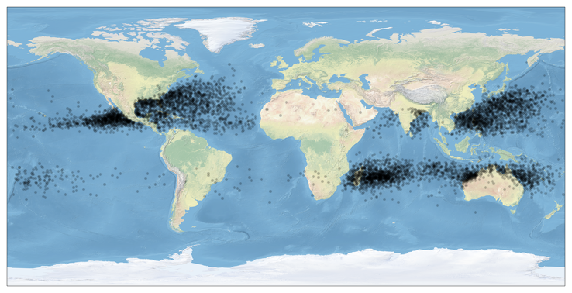

In [33]:
# create the projections and the axes
crs = ccrs.PlateCarree()
ax = plt.axes(projection=crs)
# plot the map
ax.stock_img()
# get the positions and plot the markers
x = pos.Longitude.values
y = pos.Latitude.values
ax.plot(x, y, '.k', markersize=5, alpha=0.25)

# resize image
ax.figure.set_figwidth(10)
ax.figure.set_figheight(6)

Indeed we see that the storms mostly occur around the tropics, mostly the coasts of central america, madagascar, northrn austrialia, southeast asia, and Japan.

To estimate the storm distribution, we first need to transform the storms positions from geodetic coordinates (longtitude and latitude) to the map's coordinates (plate carree).

In [34]:
geo = ccrs.Geodetic()
h = geo.transform_points(crs, x, y)[:, :2].T
h.shape

(2, 6940)

Now we perform the density estimation using `scipy.stats.gaussian_kde`, which returns a Python function which estimates the density function.

In [36]:
kde = scipy.stats.gaussian_kde(h)

We'll now apply this `kde` function to a 2D grid of points on the map.
We do this with `meshgrid`.

We set the north-south resolution to be `k` and the east-west to be `2k`, and get the cornders of the grid from the map axes.

In [42]:
k = 100
x0, x1, y0, y1 = ax.get_extent()
xrange = np.linspace(x0, x1, 2 * k)
yrange = np.linspace(y0, y1, k)

`meshgrid` returns a list of two `(k, 2k)` arrays, the first for the x coordinates of each point in the grid, and the second for the y coordinates of each point in the grid.

In [43]:
tx, ty = np.meshgrid(xrange, yrange)
tx.shape, ty.shape

((100, 200), (100, 200))

We reshape the grid for the `kde` function, which expects one or many points.

In [48]:
mesh = np.vstack((tx.ravel(), ty.ravel()))
mesh.shape, 2*k**2

((2, 20000), 20000)

We evaluate the `kde` function on the grid points, and reshape the result back to `(2, 2k)`.

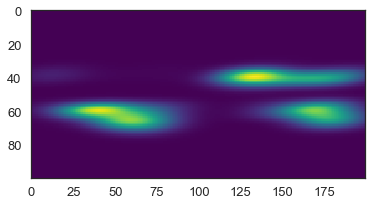

In [51]:
v = kde(mesh).reshape((k, 2 * k))
plt.imshow(v, cmap='viridis');

Before displaying the KDE heatmap on the map, we need to use a special colormap with a transparent channel.
This will allow us to superimpose the heatmap on the stock image.

In [54]:
# https://stackoverflow.com/a/37334212/1595060
cmap = plt.get_cmap('Reds')
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:, -1] = np.linspace(0, 1, cmap.N)
my_cmap = mpl.colors.ListedColormap(my_cmap);

Finally, we plot the density map on (or rather under) the geographical map.

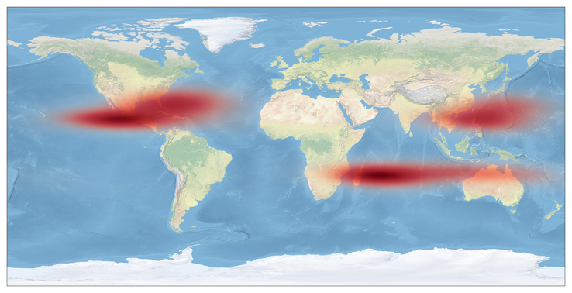

In [59]:
ax = plt.axes(projection=crs)
ax.stock_img()
ax.imshow(v, origin='lower',
         extent=[x0, x1, y0, y1],
         interpolation='bilinear',
         cmap=my_cmap)
ax.figure.set_figwidth(10)
ax.figure.set_figheight(6)

## Exercise

Consider the following random data, drawn from a 2D normal distribution:

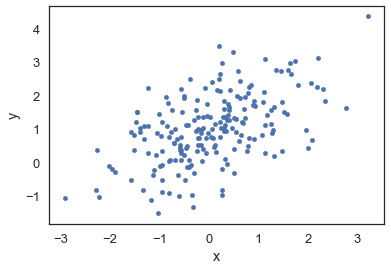

In [60]:
mean, cov = [0, 1], [(1, .5), (.5, 1)]
data = np.random.multivariate_normal(mean, cov, 200)
df = pd.DataFrame(data, columns=["x", "y"])

df.plot.scatter('x', 'y');

Use a KDE approach to estimate and plot the distribution of the random data. 
**Note** if you only want to plot, rather than actually estimate the `kde` function, you can use Seaborn's [`kdeplot`](http://web.stanford.edu/~mwaskom/software/seaborn/tutorial/distributions.html) function. Experiment with the `shade`, `cmap`, and `n_levels` keywords to get aestheticly pleasing results.

# References

- [IPython Cookbook](http://ipython-books.github.io/cookbook/): IPython Interactive Computing and Visualization Cookbook by Cyrille Rossant.
- [scipy.stats tutorial](http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html)
- [Scipy's statistical functions](http://docs.scipy.org/doc/scipy/reference/stats.html)
- [Visualizing distributions in Seaborn](http://web.stanford.edu/~mwaskom/software/seaborn/tutorial/distributions.html)
- [Basemap](http://matplotlib.org/basemap/)

## Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Python for Engineers_](https://github.com/yoavram/Py4Eng) course.

The notebook was written using [Python](http://python.org/) 3.6.1.
Dependencies listed in [environment.yml](../environment.yml), full versions in [environment_full.yml](../environment_full.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)